## Transformer

BERT中发挥重要作用的结构就是Transformer, 之后又相继出现XLNET，roBERT等模型击败了BERT，但是他们的核心没有变，仍然是：
Transformer.

相比之前占领市场的LSTM和GRU模型，Transformer有两个显著的优势:
1. Transformer能够利用分布式GPU进行并行训练，提升模型训练效率.
2. 在分析预测更长的文本时, 捕捉间隔较长的语义关联效果更好.

Transformer模型的作用：基于seq2seq架构的transformer模型可以完成NLP领域研究的典型任务, 如机器翻译, 文本生成等. 同时又可以构建预训练语言模型，用于不同任务的迁移学习.

声明:
在接下来的架构分析中, 我们将假设使用Transformer模型架构处理从一种语言文本到另一种语言文本的翻译工作, 因此很多命名方式遵循NLP中的规则. 比如: Embeddding层将称作文本嵌入层, Embedding层产生的张量称为词嵌入张量, 它的最后一维将称作词向量等.

<img src='transformer.jpg' width="40%" height="40%">

Transformer总体架构可分为四个部分:
- 输入部分
- 输出部分
- 编码器部分
- 解码器部分

## 1.1 输入层-文本嵌入层的作用

无论是源文本嵌入还是目标文本嵌入，都是为了将文本中词汇的数字表示转变为向量表示, 希望在这样的高维空间捕捉词汇间的关系.

In [1]:
# 导入必备的工具包
import torch

# 预定义的网络层torch.nn, 工具开发者已经帮助我们开发好的一些常用层, 
# 比如，卷积层, lstm层, embedding层等, 不需要我们再重新造轮子.
import torch.nn as nn

# 数学计算工具包
import math

# torch中变量封装函数Variable.
from torch.autograd import Variable

# 定义Embeddings类来实现文本嵌入层，这里s说明代表两个一模一样的嵌入层, 他们共享参数.
# 该类继承nn.Module, 这样就有标准层的一些功能, 这里我们也可以理解为一种模式, 我们自己实现的所有层都会这样去写.
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        """类的初始化函数, 有两个参数, d_model: 指词嵌入的维度, vocab: 指词表的大小."""
        # 接着就是使用super的方式指明继承nn.Module的初始化函数, 我们自己实现的所有层都会这样去写.
        super(Embeddings, self).__init__()
        # 之后就是调用nn中的预定义层Embedding, 获得一个词嵌入对象self.lut
        self.lut = nn.Embedding(vocab, d_model)
        # 最后就是将d_model传入类中
        self.d_model = d_model

    def forward(self, x):
        """可以将其理解为该层的前向传播逻辑，所有层中都会有此函数
           当传给该类的实例化对象参数时, 自动调用该类函数
           参数x: 因为Embedding层是首层, 所以代表输入给模型的文本通过词汇映射后的张量"""

        # 将x传给self.lut并与根号下self.d_model相乘作为结果返回 缩放向量作用
        return self.lut(x) * math.sqrt(self.d_model)

In [2]:
embedding = nn.Embedding(10, 3)
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
print(embedding(input))



embedding = nn.Embedding(10, 3, padding_idx=0)
input = torch.LongTensor([[0,2,0,5]])
print(embedding(input))


tensor([[[-0.5573, -0.1416, -0.4412],
         [-0.5399,  0.7922, -1.9119],
         [ 0.4832,  0.8946, -1.5273],
         [ 0.7468, -0.1664,  0.1042]],

        [[ 0.4832,  0.8946, -1.5273],
         [ 0.0758,  1.0153,  0.5370],
         [-0.5399,  0.7922, -1.9119],
         [-0.2939, -0.3253, -0.0580]]], grad_fn=<EmbeddingBackward0>)
tensor([[[ 0.0000,  0.0000,  0.0000],
         [-0.3495, -0.9721, -1.4833],
         [ 0.0000,  0.0000,  0.0000],
         [-0.6213,  1.2737, -0.1260]]], grad_fn=<EmbeddingBackward0>)


In [3]:
# 词嵌入维度是512维
d_model = 512

# 词表大小是1000
vocab = 1000
# 输入x是一个使用Variable封装的长整型张量, 形状是2 x 4
x = Variable(torch.LongTensor([[100,2,421,508],[491,998,1,221]]))
emb = Embeddings(d_model, vocab)
embr = emb(x)
print("embr:", embr)
print("shape:", embr.shape)

embr: tensor([[[ 30.9494, -36.2842,  13.2809,  ..., -33.2559,  17.2550,   1.9035],
         [  9.6173,  -8.0465,  17.4956,  ...,  21.8092, -54.0964,  27.3075],
         [-12.9375,   3.1968,  33.0719,  ..., -33.5247, -14.7724,  33.0249],
         [-12.4418,   6.3775, -14.4059,  ...,  -4.2711,  -5.6386, -11.8234]],

        [[ 12.5281,   7.0530, -29.2927,  ..., -21.6877,  -5.5432,  19.7839],
         [-14.6713,   7.0411,   2.8968,  ..., -33.1289, -14.6294,  44.0637],
         [  7.6900,   4.5530,  -8.5888,  ...,  41.7748,  18.9627,  12.2848],
         [  2.1708, -13.6755,   0.4689,  ..., -23.2775,  19.0395,   9.0944]]],
       grad_fn=<MulBackward0>)
shape: torch.Size([2, 4, 512])


## 1.2输入层-位置编码器的作用

因为在Transformer的编码器结构中, 并没有针对词汇位置信息的处理，因此需要在Embedding层后加入位置编码器，将词汇位置不同可能会产生不同语义的信息加入到词嵌入张量中, 以弥补位置信息的缺失.

In [4]:
# 定义位置编码器类, 我们同样把它看做一个层, 因此会继承nn.Module    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        """位置编码器类的初始化函数, 共有三个参数, 分别是d_model: 词嵌入维度, 
           dropout: 置0比率, max_len: 每个句子的最大长度"""
        super(PositionalEncoding, self).__init__()

        # 实例化nn中预定义的Dropout层, 并将dropout传入其中, 获得对象self.dropout
        self.dropout = nn.Dropout(p=dropout)

        # 初始化一个位置编码矩阵, 它是一个0阵，矩阵的大小是max_len x d_model.
        pe = torch.zeros(max_len, d_model)

        # 初始化一个绝对位置矩阵, 在我们这里，词汇的绝对位置就是用它的索引去表示. 
        # 所以我们首先使用arange方法获得一个连续自然数向量，然后再使用unsqueeze方法拓展向量维度使其成为矩阵， 
        # 又因为参数传的是1，代表矩阵拓展的位置，会使向量变成一个max_len x 1 的矩阵， 
        position = torch.arange(0, max_len).unsqueeze(1)

        # 绝对位置矩阵初始化之后，接下来就是考虑如何将这些位置信息加入到位置编码矩阵中，
        # 最简单思路就是先将max_len x 1的绝对位置矩阵， 变换成max_len x d_model形状，然后覆盖原来的初始位置编码矩阵即可， 
        # 要做这种矩阵变换，就需要一个1xd_model形状的变换矩阵div_term，我们对这个变换矩阵的要求除了形状外，
        # 还希望它能够将自然数的绝对位置编码缩放成足够小的数字，有助于在之后的梯度下降过程中更快的收敛.  这样我们就可以开始初始化这个变换矩阵了.
        # 首先使用arange获得一个自然数矩阵， 但是细心的同学们会发现， 我们这里并没有按照预计的一样初始化一个1xd_model的矩阵， 
        # 而是有了一个跳跃，只初始化了一半即1xd_model/2 的矩阵。 为什么是一半呢，其实这里并不是真正意义上的初始化了一半的矩阵，
        # 我们可以把它看作是初始化了两次，而每次初始化的变换矩阵会做不同的处理，第一次初始化的变换矩阵分布在正弦波上， 第二次初始化的变换矩阵分布在余弦波上， 
        # 并把这两个矩阵分别填充在位置编码矩阵的偶数和奇数位置上，组成最终的位置编码矩阵.
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model)) #缩放
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # 这样我们就得到了位置编码矩阵pe, pe现在还只是一个二维矩阵，要想和embedding的输出（一个三维张量）相加，
        # 就必须拓展一个维度，所以这里使用unsqueeze拓展维度.
        pe = pe.unsqueeze(0)

        # 最后把pe位置编码矩阵注册成模型的buffer，什么是buffer呢，
        # 我们把它认为是对模型效果有帮助的，但是却不是模型结构中超参数或者参数，不需要随着优化步骤进行更新的增益对象. 
        # 注册之后我们就可以在模型保存后重加载时和模型结构与参数一同被加载.
        self.register_buffer('pe', pe)

    def forward(self, x):
        """forward函数的参数是x, 表示文本序列的词嵌入表示"""
        # 在相加之前我们对pe做一些适配工作， 将这个三维张量的第二维也就是句子最大长度的那一维将切片到与输入的x的第二维相同即x.size(1)，
        # 因为我们默认max_len为5000一般来讲实在太大了，很难有一条句子包含5000个词汇，所以要进行与输入张量的适配. 
        # 最后使用Variable进行封装，使其与x的样式相同，但是它是不需要进行梯度求解的，因此把requires_grad设置成false.
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        # 最后使用self.dropout对象进行'丢弃'操作, 并返回结果.
        return self.dropout(x)

In [5]:
# 词嵌入维度是512维
d_model = 512

# 置0比率为0.1
dropout = 0.1

# 句子最大长度
max_len=60
# 输入x是Embedding层的输出的张量, 形状是2 x 4 x 512
x = embr
pe = PositionalEncoding(d_model, dropout, max_len)
pe_result = pe(x)
print("pe_result:", pe_result)
print("pe_result:", pe_result.shape)

pe_result: tensor([[[ 34.3882, -39.2046,  14.7566,  ..., -35.8399,  19.1722,   3.2261],
         [ 11.6208,  -8.3402,  20.3527,  ...,  25.3436, -60.1070,  31.4528],
         [-13.3646,   3.0896,  37.7870,  ..., -36.1386, -16.4136,   0.0000],
         [-13.6674,   5.9861, -15.7343,  ...,  -3.6345,  -6.2648, -12.0260]],

        [[ 13.9201,   0.0000, -32.5474,  ..., -22.9863,  -6.1591,  23.0932],
         [-15.3665,   8.4238,   4.1319,  ..., -35.6988, -16.2548,  50.0707],
         [  9.5548,   4.5966,  -8.5027,  ...,  47.5275,  21.0700,  14.7609],
         [  2.5688, -16.2950,   0.7934,  ..., -24.7528,  21.1554,  11.2160]]],
       grad_fn=<MulBackward0>)
pe_result: torch.Size([2, 4, 512])


In [6]:
div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
div_term

tensor([1.0000e+00, 9.6466e-01, 9.3057e-01, 8.9769e-01, 8.6596e-01, 8.3536e-01,
        8.0584e-01, 7.7737e-01, 7.4989e-01, 7.2339e-01, 6.9783e-01, 6.7317e-01,
        6.4938e-01, 6.2643e-01, 6.0430e-01, 5.8294e-01, 5.6234e-01, 5.4247e-01,
        5.2330e-01, 5.0481e-01, 4.8697e-01, 4.6976e-01, 4.5316e-01, 4.3714e-01,
        4.2170e-01, 4.0679e-01, 3.9242e-01, 3.7855e-01, 3.6517e-01, 3.5227e-01,
        3.3982e-01, 3.2781e-01, 3.1623e-01, 3.0505e-01, 2.9427e-01, 2.8387e-01,
        2.7384e-01, 2.6416e-01, 2.5483e-01, 2.4582e-01, 2.3714e-01, 2.2876e-01,
        2.2067e-01, 2.1288e-01, 2.0535e-01, 1.9810e-01, 1.9110e-01, 1.8434e-01,
        1.7783e-01, 1.7154e-01, 1.6548e-01, 1.5963e-01, 1.5399e-01, 1.4855e-01,
        1.4330e-01, 1.3824e-01, 1.3335e-01, 1.2864e-01, 1.2409e-01, 1.1971e-01,
        1.1548e-01, 1.1140e-01, 1.0746e-01, 1.0366e-01, 1.0000e-01, 9.6466e-02,
        9.3057e-02, 8.9769e-02, 8.6596e-02, 8.3536e-02, 8.0584e-02, 7.7736e-02,
        7.4989e-02, 7.2339e-02, 6.9783e-

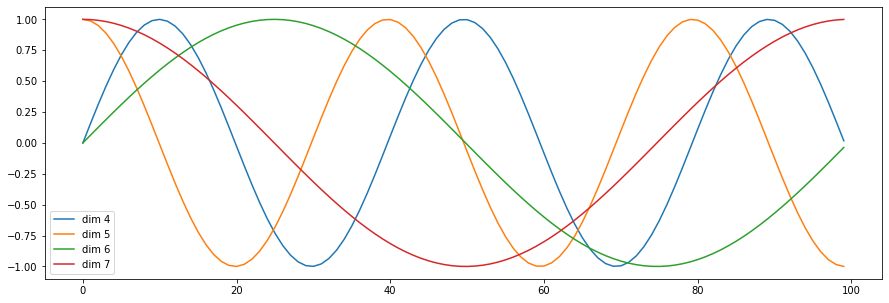

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一张15 x 5大小的画布
plt.figure(figsize=(15, 5))

# 实例化PositionalEncoding类得到pe对象, 输入参数是20和0
pe = PositionalEncoding(20, 0)

# 然后向pe传入被Variable封装的tensor, 这样pe会直接执行forward函数, 
# 且这个tensor里的数值都是0, 被处理后相当于位置编码张量
y = pe(Variable(torch.zeros(1, 100, 20)))

# 然后定义画布的横纵坐标, 横坐标到100的长度, 纵坐标是某一个词汇中的某维特征在不同长度下对应的值
# 因为总共有20维之多, 我们这里只查看4，5，6，7维的值.
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())

# 在画布上填写维度提示信息
plt.legend(["dim %d"%p for p in [4,5,6,7]])

效果分析:
- 每条颜色的曲线代表某一个词汇中的特征在不同位置的含义.
- 保证同一词汇随着所在位置不同它对应位置嵌入向量会发生变化.(x轴代表句子中词汇位置)
- 正弦波和余弦波的值域范围都是1到-1这又很好的控制了嵌入数值的大小, 有助于梯度的快速计算.

# 编码器部分实现
## 2.1 掩码张量

掩码张量的作用:
在transformer中, 掩码张量的主要作用在应用attention(将在下一小节讲解)时，有一些生成的attention张量中的值计算有可能已知了未来信息而得到的，未来信息被看到是因为训练时会把整个输出结果都一次性进行Embedding，但是理论上解码器的的输出却不是一次就能产生最终结果的，而是一次次通过上一次结果综合得出的，因此，未来的信息可能被提前利用. 所以，我们会进行遮掩.

In [8]:
def subsequent_mask(size):
    """生成向后遮掩的掩码张量, 参数size是掩码张量最后两个维度的大小, 它的最后两维形成一个方阵"""
    # 在函数中, 首先定义掩码张量的形状
    attn_shape = (1, size, size)

    # 然后使用np.ones方法向这个形状中添加1元素,形成上三角阵, 最后为了节约空间, 
    # 再使其中的数据类型变为无符号8位整形unit8 
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')

    # 最后将numpy类型转化为torch中的tensor, 内部做一个1 - 的操作, 
    # 在这个其实是做了一个三角阵的反转, subsequent_mask中的每个元素都会被1减, 
    # 如果是0, subsequent_mask中的该位置由0变成1
    # 如果是1, subsequent_mask中的该位置由1变成0 
    return torch.from_numpy(1 - subsequent_mask)

In [9]:
np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], k=1) # k=-1 0 1

array([[0, 2, 3],
       [0, 0, 6],
       [0, 0, 0],
       [0, 0, 0]])

In [10]:
# 生成的掩码张量的最后两维的大小
size = 5
sm = subsequent_mask(size)
print("sm:", sm)

sm: tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)


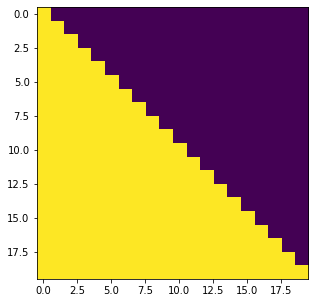

In [11]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

效果分析:
- 通过观察可视化方阵, 黄色是1的部分, 这里代表被遮掩, 紫色代表没有被遮掩的信息, 横坐标代表目标词汇的位置, 纵坐标代表可查看的位置;
- 我们看到, 在0的位置我们一看望过去都是黄色的, 都被遮住了，1的位置一眼望过去还是黄色, 说明第一次词还没有产生, 从第二个位置看过去, 就能看到位置1的词, 其他位置看不到, 以此类推.

## 2.2 Attention

使用乘性attention

注意力机制是注意力计算规则能够应用的深度学习网络的载体, 除了注意力计算规则外, 还包括一些必要的全连接层以及相关张量处理, 使其与应用网络融为一体. 使用自注意力计算规则的注意力机制称为自注意力机制.

<img src='attention_in_network.png' width='50%' height='50%'>


In [12]:
import torch.nn.functional as F
def attention(query, key, value, mask=None, dropout=None):
    """注意力机制的实现, 输入分别是query, key, value, mask: 掩码张量, 
       dropout是nn.Dropout层的实例化对象, 默认为None"""
    # 在函数中, 首先取query的最后一维的大小, 一般情况下就等同于我们的词嵌入维度, 命名为d_k
    d_k = query.size(-1)
    # 按照注意力公式, 将query与key的转置相乘, 这里面key是将最后两个维度进行转置, 再除以缩放系数根号下d_k, 这种计算方法也称为缩放点积注意力计算.
    # 得到注意力得分张量scores
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    # 接着判断是否使用掩码张量
    if mask is not None:
        # 使用tensor的masked_fill方法, 将掩码张量和scores张量每个位置一一比较, 如果掩码张量处为0
        # 则对应的scores张量用-1e9这个值来替换, 太小不会被选中, 如下演示
        scores = scores.masked_fill(mask == 0, -1e9)

    # 对scores的最后一维进行softmax操作, 使用F.softmax方法, 第一个参数是softmax对象, 第二个是目标维度.
    # 这样获得最终的注意力张量
    p_attn = F.softmax(scores, dim = -1)

    # 之后判断是否使用dropout进行随机置0
    if dropout is not None:
        # 将p_attn传入dropout对象中进行'丢弃'处理
        p_attn = dropout(p_attn)

    # 最后, 根据公式将p_attn与value张量相乘获得最终的query注意力表示, 同时返回注意力张量
    return torch.matmul(p_attn, value), p_attn

Variable是对Tensor的封装，操作与tensor基本一致，不同的是，每一个Variable被构建的时候，都包含三个属性：
- Variable中所包含的tensor
- tensor的梯度 .grad
- 以何种方式得到这种梯度 .grad_fn

之所以有Variable这个数据结构，是为了引入计算图（自动求导），方便构建神经网络。

In [13]:
input = Variable(torch.randn(5, 5))
mask = Variable(torch.zeros(5, 5))
input.masked_fill(mask == 0, -1e9)

tensor([[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]])

In [14]:
query = key = value = pe_result
attn, p_attn = attention(query, key, value)
print(attn.shape)
print(p_attn.shape)

torch.Size([2, 4, 512])
torch.Size([2, 4, 4])


## 2.3 多头注意力机制

每个头开始从词义层面分割输出的张量，也就是每个头都想获得一组Q，K，V进行注意力机制的计算，但是句子中的每个词的表示只获得一部分，也就是只分割了最后一维的词嵌入向量. 这就是所谓的多头，将每个头的获得的输入送到注意力机制中, 就形成多头注意力机制.

<img src='multihead.png' width='50%' height='50%'>

多头注意力机制的作用:
- 这种结构设计能让每个注意力机制去优化每个词汇的不同特征部分，从而均衡同一种注意力机制可能产生的偏差，让词义拥有来自更多元的表达，实验表明可以从而提升模型效果。


In [15]:
# 用于深度拷贝的copy工具包
import copy

# 首先需要定义克隆函数, 因为在多头注意力机制的实现中, 用到多个结构相同的线性层.
# 我们将使用clone函数将他们一同初始化在一个网络层列表对象中. 之后的结构中也会用到该函数.
def clones(module, N):
    """用于生成相同网络层的克隆函数, 它的参数module表示要克隆的目标网络层, N代表需要克隆的数量"""
    # 在函数中, 我们通过for循环对module进行N次深度拷贝, 使其每个module成为独立的层,
    # 然后将其放在nn.ModuleList类型的列表中存放.
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


# 我们使用一个类来实现多头注意力机制的处理
class MultiHeadedAttention(nn.Module):
    def __init__(self, head, embedding_dim, dropout=0.1):
        """在类的初始化时, 会传入三个参数，head代表头数，embedding_dim代表词嵌入的维度， 
           dropout代表进行dropout操作时置0比率，默认是0.1."""
        super(MultiHeadedAttention, self).__init__()

        # 在函数中，首先使用了一个测试中常用的assert语句，判断h是否能被d_model整除，
        # 这是因为我们之后要给每个头分配等量的词特征.也就是embedding_dim/head个.
        assert embedding_dim % head == 0

        # 得到每个头获得的分割词向量维度d_k
        self.d_k = embedding_dim // head

        # 传入头数h
        self.head = head

        # 然后获得线性层对象，通过nn的Linear实例化，它的内部变换矩阵是embedding_dim x embedding_dim，然后使用clones函数克隆四个，
        # 为什么是四个呢，这是因为在多头注意力中，Q，K，V各需要一个，最后拼接的矩阵还需要一个，因此一共是四个.
        self.linears = clones(nn.Linear(embedding_dim, embedding_dim), 4)

        # self.attn为None，它代表最后得到的注意力张量，现在还没有结果所以为None.
        self.attn = None

        # 最后就是一个self.dropout对象，它通过nn中的Dropout实例化而来，置0比率为传进来的参数dropout.
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        """前向逻辑函数, 它的输入参数有四个，前三个就是注意力机制需要的Q, K, V，
           最后一个是注意力机制中可能需要的mask掩码张量，默认是None. """

        # 如果存在掩码张量mask
        if mask is not None:
            # 使用unsqueeze拓展维度
            mask = mask.unsqueeze(0)

        # 接着，我们获得一个batch_size的变量，他是query尺寸的第1个数字，代表有多少条样本.
        batch_size = query.size(0)

        # 之后就进入多头处理环节
        # 首先利用zip将输入QKV与三个线性层组到一起，然后使用for循环，将输入QKV分别传到线性层中，
        # 做完线性变换后，开始为每个头分割输入，这里使用view方法对线性变换的结果进行维度重塑，多加了一个维度h，代表头数，
        # 这样就意味着每个头可以获得一部分词特征组成的句子，其中的-1代表自适应维度，
        # 计算机会根据这种变换自动计算这里的值.然后对第二维和第三维进行转置操作，
        # 为了让代表句子长度维度和词向量维度能够相邻，这样注意力机制才能找到词义与句子位置的关系，
        # 从attention函数中可以看到，利用的是原始输入的倒数第一和第二维.这样我们就得到了每个头的输入.
        query, key, value = \
           [model(x).view(batch_size, -1, self.head, self.d_k).transpose(1, 2)
            for model, x in zip(self.linears, (query, key, value))]

        # 得到每个头的输入后，接下来就是将他们传入到attention中，
        # 这里直接调用我们之前实现的attention函数.同时也将mask和dropout传入其中.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 通过多头注意力计算后，我们就得到了每个头计算结果组成的4维张量，我们需要将其转换为输入的形状以方便后续的计算，
        # 因此这里开始进行第一步处理环节的逆操作，先对第二和第三维进行转置，然后使用contiguous方法，
        # 这个方法的作用就是能够让转置后的张量应用view方法，否则将无法直接使用，
        # 所以，下一步就是使用view重塑形状，变成和输入形状相同.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.head * self.d_k)

        # 最后使用线性层列表中的最后一个线性层对输入进行线性变换得到最终的多头注意力结构的输出.
        return self.linears[-1](x)

In [16]:
# 头数head
head = 8

# 词嵌入维度embedding_dim
embedding_dim = 512

# 置零比率dropout
dropout = 0.2

# 假设输入的Q，K，V仍然相等
query = value = key = pe_result

# 输入的掩码张量mask
mask = Variable(torch.zeros(8, 4, 4))

mha = MultiHeadedAttention(head, embedding_dim, dropout)
mha_result = mha(query, key, value, mask)
print(mha_result)

tensor([[[  2.3061,   5.2327,  -2.5486,  ..., -10.1967,  -3.1370,  -4.1268],
         [  0.9208,   2.0680,  -3.0705,  ...,  -8.2841,  -2.6933,  -5.6916],
         [  4.7115,   6.3741,  -1.2158,  ...,  -9.4130,  -1.9625,  -5.2179],
         [  0.1695,   5.5457,   0.3954,  ...,  -8.6759,  -1.5939,  -2.1679]],

        [[ -2.3666,   0.3355,   0.2725,  ...,   4.6019,   8.5773,  -0.9455],
         [ -4.9969,   1.5961,   2.3064,  ...,  -2.4735,   3.3144,  -0.4199],
         [ -0.5995,   0.1960,   3.6703,  ...,   2.7945,   5.2435,  -2.4943],
         [  1.1229,  -0.2735,  -0.7335,  ...,   4.0641,   7.3343,  -1.3963]]],
       grad_fn=<AddBackward0>)


## 2.4 前馈全连接层

什么是前馈全连接层:
- 在Transformer中前馈全连接层就是具有两层线性层的全连接网络.

前馈全连接层的作用:
- 考虑注意力机制可能对复杂过程的拟合程度不够, 通过增加两层网络来增强模型的能力.

In [17]:
# 通过类PositionwiseFeedForward来实现前馈全连接层
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        """初始化函数有三个输入参数分别是d_model, d_ff,和dropout=0.1，第一个是线性层的输入维度也是第二个线性层的输出维度，
           因为我们希望输入通过前馈全连接层后输入和输出的维度不变. 第二个参数d_ff就是第二个线性层的输入维度和第一个线性层的输出维度. 
           最后一个是dropout置0比率."""
        super(PositionwiseFeedForward, self).__init__()

        # 首先按照我们预期使用nn实例化了两个线性层对象，self.w1和self.w2
        # 它们的参数分别是d_model, d_ff和d_ff, d_model
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        # 然后使用nn的Dropout实例化了对象self.dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """输入参数为x，代表来自上一层的输出"""
        # 首先经过第一个线性层，然后使用Funtional中relu函数进行激活,
        # 之后再使用dropout进行随机置0，最后通过第二个线性层w2，返回最终结果.
        return self.w2(self.dropout(F.relu(self.w1(x))))

In [18]:
d_model = 512

# 线性变化的维度
d_ff = 64

dropout = 0.2
x = mha_result
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
ff_result = ff(x)
print(ff_result.shape)

torch.Size([2, 4, 512])


## 2.5 规范化层

规范化层的作用:
- 它是所有深层网络模型都需要的标准网络层，因为随着网络层数的增加，通过多层的计算后参数可能开始出现过大或过小的情况，这样可能会导致学习过程出现异常，模型可能收敛非常的慢. 因此都会在一定层数后接规范化层进行数值的规范化，使其特征数值在合理范围内.

In [19]:
# 通过LayerNorm实现规范化层的类
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        """初始化函数有两个参数, 一个是features, 表示词嵌入的维度,
           另一个是eps它是一个足够小的数, 在规范化公式的分母中出现,
           防止分母为0.默认是1e-6."""
        super(LayerNorm, self).__init__()

        # 根据features的形状初始化两个参数张量a2，和b2，第一个初始化为1张量，
        # 也就是里面的元素都是1，第二个初始化为0张量，也就是里面的元素都是0，这两个张量就是规范化层的参数，
        # 因为直接对上一层得到的结果做规范化公式计算，将改变结果的正常表征，因此就需要有参数作为调节因子，
        # 使其即能满足规范化要求，又能不改变针对目标的表征.
        # 最后使用nn.parameter封装，代表他们是模型的参数。会参与训练
        self.a2 = nn.Parameter(torch.ones(features))
        self.b2 = nn.Parameter(torch.zeros(features))

        # 把eps传到类中
        self.eps = eps

    def forward(self, x):
        """输入参数x代表来自上一层的输出"""
        # 在函数中，首先对输入变量x求其最后一个维度的均值，并保持输出维度与输入维度一致.
        # 接着再求最后一个维度的标准差，然后就是根据规范化公式，用x减去均值除以标准差获得规范化的结果，
        # 最后对结果乘以我们的缩放参数，即a2，*号代表同型点乘，即对应位置进行乘法操作，加上位移参数b2.返回即可.
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a2 * (x - mean) / (std + self.eps) + self.b2 #减去均值 除标准差

In [20]:
features = d_model = 512
eps = 1e-6
x = ff_result
ln = LayerNorm(features, eps)
ln_result = ln(x)
print(ln_result.shape)

torch.Size([2, 4, 512])


## 2.6 子层连接结构

输入到每个子层以及规范化层的过程中，还使用了残差链接（跳跃连接），因此我们把这一部分结构整体叫做子层连接（代表子层及其链接结构），在每个编码器层中，都有两个子层，这两个子层加上周围的链接结构就形成了两个子层连接结构.

<img src='sub_struture.png' width='30%' height='30%'>

In [21]:
# 使用SublayerConnection来实现子层连接结构的类
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout=0.1):
        """它输入参数有两个, size以及dropout， size一般是都是词嵌入维度的大小， 
           dropout本身是对模型结构中的节点数进行随机抑制的比率， 
           又因为节点被抑制等效就是该节点的输出都是0，因此也可以把dropout看作是对输出矩阵的随机置0的比率.
        """
        super(SublayerConnection, self).__init__()
        # 实例化了规范化对象self.norm
        self.norm = LayerNorm(size)
        # 又使用nn中预定义的droupout实例化一个self.dropout对象.
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, sublayer):
        """前向逻辑函数中, 接收上一个层或者子层的输入作为第一个参数，
           将该子层连接中的子层函数作为第二个参数"""

        # 我们首先对输出进行规范化，然后将结果传给子层处理，之后再对子层进行dropout操作，
        # 随机停止一些网络中神经元的作用，来防止过拟合. 最后还有一个add操作， 
        # 因为存在跳跃连接(残差连接)，所以是将输入x与dropout后的子层输出结果相加作为最终的子层连接输出.
        return x + self.dropout(sublayer(self.norm(x)))

In [22]:
size = 512
dropout = 0.2
head = 8
d_model = 512
# 令x为位置编码器的输出
x = pe_result
mask = Variable(torch.zeros(8, 4, 4))

# 假设子层中装的是多头注意力层, 实例化这个类
self_attn =  MultiHeadedAttention(head, d_model)

# 使用lambda获得一个函数类型的子层
sublayer = lambda x: self_attn(x, x, x, mask)

sc = SublayerConnection(size, dropout)
sc_result = sc(x, sublayer)
print(sc_result)
print(sc_result.shape)

tensor([[[ 34.6059, -38.9431,  15.0498,  ..., -35.5778,  19.1801,   3.0505],
         [ 11.8112,  -8.0527,  20.6506,  ...,  25.3436, -60.0642,  31.2661],
         [-13.2232,   3.3305,  38.1117,  ..., -36.1386, -16.4136,  -0.1965],
         [-13.5592,   6.2529, -15.7343,  ...,  -3.5271,  -6.3801, -12.4512]],

        [[ 13.5068,  -0.0650, -32.4528,  ..., -22.9863,  -6.1114,  23.0932],
         [-15.8846,   8.3140,   4.1319,  ..., -35.9826, -16.0486,  49.7705],
         [  9.2165,   4.5966,  -8.2363,  ...,  47.3037,  21.1905,  14.3874],
         [  2.0890, -16.4535,   1.1125,  ..., -24.9378,  21.3817,  10.9782]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## 2.7 编码器层

作为编码器的组成单元, 每个编码器层完成一次对输入的特征提取过程, 即编码过程.


<img src='encoder.png' width='30%' height='30%'>

In [23]:
# 使用EncoderLayer类实现编码器层
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        """它的初始化函数参数有四个，分别是size，其实就是我们词嵌入维度的大小，它也将作为我们编码器层的大小, 
           第二个self_attn，之后我们将传入多头自注意力子层实例化对象, 并且是自注意力机制, 
           第三个是feed_froward, 之后我们将传入前馈全连接层实例化对象, 最后一个是置0比率dropout."""
        super(EncoderLayer, self).__init__()

        # 首先将self_attn和feed_forward传入其中.
        self.self_attn = self_attn
        self.feed_forward = feed_forward

        # 如图所示, 编码器层中有两个子层连接结构, 所以使用clones函数进行克隆
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        # 把size传入其中
        self.size = size

    def forward(self, x, mask):
        """forward函数中有两个输入参数，x和mask，分别代表上一层的输出，和掩码张量mask."""
        # 里面就是按照结构图左侧的流程. 首先通过第一个子层连接结构，其中包含多头自注意力子层，
        # 然后通过第二个子层连接结构，其中包含前馈全连接子层. 最后返回结果.
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [24]:
size = 512
head = 8
d_model = 512
d_ff = 64
x = pe_result
dropout = 0.2
self_attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
mask = Variable(torch.zeros(8, 4, 4))
el = EncoderLayer(size, self_attn, ff, dropout)
el_result = el(x, mask)
print(el_result)
print(el_result.shape)

tensor([[[ 34.7989, -39.2792,  14.9392,  ..., -35.5555,  19.0857,   2.7400],
         [ 10.8788,  -8.8975,  20.5405,  ...,  25.3430, -60.5728,  31.2279],
         [-13.3808,   2.5237,  38.0771,  ..., -36.0830, -16.7628,   0.0726],
         [-14.4228,   5.2722, -16.4436,  ...,  -3.6737,  -6.5779, -12.3415]],

        [[ 13.6805,  -0.3977, -32.3819,  ..., -22.4362,  -6.4509,  22.8038],
         [-15.9264,   8.5561,   4.3930,  ..., -35.4902, -16.1709,  50.0758],
         [  9.5548,   4.5966,  -8.7735,  ...,  48.1046,  21.1849,  14.4070],
         [  1.8620, -15.9688,   0.7934,  ..., -24.4145,  21.1029,  10.8068]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## 2.8 编码器

编码器用于对输入进行指定的特征提取过程, 也称为编码, 由N个编码器层堆叠而成.

In [25]:
# 使用Encoder类来实现编码器
class Encoder(nn.Module):
    def __init__(self, layer, N):
        """初始化函数的两个参数分别代表编码器层和编码器层的个数"""
        super(Encoder, self).__init__()
        # 首先使用clones函数克隆N个编码器层放在self.layers中
        self.layers = clones(layer, N)
        # 再初始化一个规范化层, 它将用在编码器的最后面.
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        """forward函数的输入和编码器层相同, x代表上一层的输出, mask代表掩码张量"""
        # 首先就是对我们克隆的编码器层进行循环，每次都会得到一个新的x，
        # 这个循环的过程，就相当于输出的x经过了N个编码器层的处理. 
        # 最后再通过规范化层的对象self.norm进行处理，最后返回结果. 
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [26]:
# 第一个实例化参数layer, 它是一个编码器层的实例化对象, 因此需要传入编码器层的参数
# 又因为编码器层中的子层是不共享的, 因此需要使用深度拷贝各个对象.
size = 512
head = 8
d_model = 512
d_ff = 64
c = copy.deepcopy
attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
dropout = 0.2
layer = EncoderLayer(size, c(attn), c(ff), dropout)

# 编码器中编码器层的个数N
N = 8
mask = Variable(torch.zeros(8, 4, 4))

en = Encoder(layer, N)
en_result = en(x, mask)
print(en_result)
print(en_result.shape)

tensor([[[ 1.3623, -1.8107,  0.4083,  ..., -1.7711,  0.8383,  0.1234],
         [ 0.3858, -0.2341,  0.6708,  ...,  0.8142, -2.2659,  1.1617],
         [-0.6664,  0.1509,  1.4399,  ..., -1.7244, -0.5247, -0.0049],
         [-0.7285,  0.1820, -0.7305,  ..., -0.3510, -0.3950, -0.5995]],

        [[ 0.5591,  0.0088, -1.3274,  ..., -1.0709, -0.1683,  0.9579],
         [-0.7371,  0.3672,  0.1572,  ..., -1.4898, -0.5543,  2.1229],
         [ 0.1358, -0.0217, -0.4438,  ...,  1.9122,  0.7475,  0.6437],
         [-0.0117, -0.7489, -0.2157,  ..., -1.2147,  1.0078,  0.3414]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## 3. 解码器
### 3.1 解码器层

作为解码器的组成单元, 每个解码器层根据给定的输入向目标方向进行特征提取操作，即解码过程.

解码器部分:
- 由N个解码器层堆叠而成
- 每个解码器层由三个子层连接结构组成
- 第一个子层连接结构包括一个多头自注意力子层和规范化层以及一个残差连接
- 第二个子层连接结构包括一个多头注意力子层和规范化层以及一个残差连接
- 第三个子层连接结构包括一个前馈全连接子层和规范化层以及一个残差连接


<img src='decoder.jpg' width='30%' height='30%'>

In [27]:
# 使用DecoderLayer的类实现解码器层
# mask机制参考：https://ifwind.github.io/2021/08/17/Transformer相关——（7）Mask机制/#self-attention中的padding-mask
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        """初始化函数的参数有5个, 分别是size，代表词嵌入的维度大小, 同时也代表解码器层的尺寸，
            第二个是self_attn，多头自注意力对象，也就是说这个注意力机制需要Q=K=V， 
            第三个是src_attn，多头注意力对象，这里Q!=K=V， 第四个是前馈全连接层对象，最后就是droupout置0比率.
        """
        super(DecoderLayer, self).__init__()
        # 在初始化函数中， 主要就是将这些输入传到类中
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        # 按照结构图使用clones函数克隆三个子层连接对象.
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, source_mask, target_mask):
        """forward函数中的参数有4个，分别是来自上一层的输入x，
           来自编码器层的语义存储变量mermory， 以及源数据掩码张量和目标数据掩码张量.
        """
        # 将memory表示成m方便之后使用
        m = memory

        # 将x传入第一个子层结构，第一个子层结构的输入分别是x和self-attn函数，因为是自注意力机制，所以Q,K,V都是x，
        # 最后一个参数是目标数据掩码张量，这时要对目标数据进行遮掩，因为此时模型可能还没有生成任何目标数据，
        # 比如在解码器准备生成第一个字符或词汇时，我们其实已经传入了第一个字符以便计算损失，
        # 但是我们不希望在生成第一个字符时模型能利用这个信息，因此我们会将其遮掩，同样生成第二个字符或词汇时，
        # 模型只能使用第一个字符或词汇信息，第二个字符以及之后的信息都不允许被模型使用.
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, target_mask))

        # 接着进入第二个子层，这个子层中常规的注意力机制，q是输入x; k，v是编码层输出memory,
        # 同样也传入source_mask，但是进行源数据遮掩的原因并非是抑制信息泄漏，而是遮蔽掉对结果没有意义的字符而产生的注意力值，
        # 以此提升模型效果和训练速度. 这样就完成了第二个子层的处理.
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, source_mask))

        # 最后一个子层就是前馈全连接子层，经过它的处理后就可以返回结果.这就是我们的解码器层结构.
        return self.sublayer[2](x, self.feed_forward)

In [28]:
# 类的实例化参数与解码器层类似, 相比多出了src_attn, 但是和self_attn是同一个类.
head = 8
size = 512
d_model = 512
d_ff = 64
dropout = 0.2
# 便于演示
self_attn = src_attn = MultiHeadedAttention(head, d_model, dropout)

# 前馈全连接层也和之前相同 
ff = PositionwiseFeedForward(d_model, d_ff, dropout)

# x是来自目标数据的词嵌入表示, 但形式和源数据的词嵌入表示相同, 这里使用per充当.
x = pe_result

# memory是来自编码器的输出
memory = en_result

# 实际中source_mask和target_mask并不相同, 这里为了方便计算使他们都为mask
mask = Variable(torch.zeros(8, 4, 4))
source_mask = target_mask = mask

dl = DecoderLayer(size, self_attn, src_attn, ff, dropout)
dl_result = dl(x, memory, source_mask, target_mask)
print(dl_result)
print(dl_result.shape)

tensor([[[ 3.3667e+01, -4.0377e+01,  1.5298e+01,  ..., -3.5727e+01,
           1.9212e+01,  4.3357e+00],
         [ 1.1222e+01, -9.3679e+00,  2.0945e+01,  ...,  2.5022e+01,
          -6.0990e+01,  3.3208e+01],
         [-1.3504e+01,  2.7591e+00,  3.7538e+01,  ..., -3.5780e+01,
          -1.7045e+01,  1.3150e+00],
         [-1.4286e+01,  5.2810e+00, -1.5845e+01,  ..., -3.5571e+00,
          -6.7822e+00, -1.1425e+01]],

        [[ 1.3931e+01, -9.5005e-03, -3.2516e+01,  ..., -2.3002e+01,
          -5.9113e+00,  2.3120e+01],
         [-1.4748e+01,  8.3320e+00,  3.6625e+00,  ..., -3.5952e+01,
          -1.6503e+01,  5.0320e+01],
         [ 9.8948e+00,  4.5139e+00, -8.4987e+00,  ...,  4.7216e+01,
           2.0626e+01,  1.4718e+01],
         [ 2.7673e+00, -1.6119e+01,  4.8671e-01,  ..., -2.4733e+01,
           2.1500e+01,  1.1172e+01]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## 3.2 解码器

根据编码器的结果以及上一次预测的结果, 对下一次可能出现的'值'进行特征表示.

In [29]:
# 使用类Decoder来实现解码器
class Decoder(nn.Module):
    def __init__(self, layer, N):
        """初始化函数的参数有两个，第一个就是解码器层layer，第二个是解码器层的个数N."""
        super(Decoder, self).__init__()
        # 首先使用clones方法克隆了N个layer，然后实例化了一个规范化层. 
        # 因为数据走过了所有的解码器层后最后要做规范化处理. 
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, source_mask, target_mask):
        """forward函数中的参数有4个，x代表目标数据的嵌入表示，memory是编码器层的输出，
           source_mask, target_mask代表源数据和目标数据的掩码张量"""

        # 然后就是对每个层进行循环，当然这个循环就是变量x通过每一个层的处理，
        # 得出最后的结果，再进行一次规范化返回即可. 
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        return self.norm(x)

In [30]:
# 分别是解码器层layer和解码器层的个数N
size = 512
d_model = 512
head = 8
d_ff = 64
dropout = 0.2
c = copy.deepcopy
attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
layer = DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout)
N = 8

# 输入参数与解码器层的输入参数相同
x = pe_result
memory = en_result
mask = Variable(torch.zeros(8, 4, 4))
source_mask = target_mask = mask

de = Decoder(layer, N)
de_result = de(x, memory, source_mask, target_mask)
print(de_result)
print(de_result.shape)

tensor([[[ 1.5209, -1.7014,  0.4084,  ..., -1.5794,  0.7175,  0.0579],
         [ 0.4435, -0.2362,  0.5822,  ...,  1.0188, -2.4017,  1.2303],
         [-0.4984,  0.2878,  1.1543,  ..., -1.4284, -0.5952, -0.0277],
         [-0.6450,  0.2882, -0.7802,  ..., -0.1960, -0.2840, -0.6139]],

        [[ 0.5923, -0.0627, -1.3117,  ..., -0.7462, -0.2288,  0.9756],
         [-0.5094,  0.1657,  0.2962,  ..., -1.2827, -0.6196,  2.1710],
         [ 0.3620, -0.0301, -0.3142,  ...,  2.0616,  0.5909,  0.5938],
         [ 0.0722, -0.7885,  0.0886,  ..., -0.9786,  0.6390,  0.4999]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## 4.输出部分实现

输出部分包含:
- 线性层： 通过对上一步的线性变化得到指定维度的输出, 也就是转换维度的作用.
- softmax层：使最后一维的向量中的数字缩放到0-1的概率值域内, 并满足他们的和为1.

In [31]:
# nn.functional工具包装载了网络层中那些只进行计算, 而没有参数的层
import torch.nn.functional as F

# 将线性层和softmax计算层一起实现, 因为二者的共同目标是生成最后的结构
# 因此把类的名字叫做Generator, 生成器类
class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        """初始化函数的输入参数有两个, d_model代表词嵌入维度, vocab_size代表词表大小."""
        super(Generator, self).__init__()
        # 首先就是使用nn中的预定义线性层进行实例化, 得到一个对象self.project等待使用, 
        # 这个线性层的参数有两个, 就是初始化函数传进来的两个参数: d_model, vocab_size
        self.project = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """前向逻辑函数中输入是上一层的输出张量x"""
        # 在函数中, 首先使用上一步得到的self.project对x进行线性变化, 
        # 然后使用F中已经实现的log_softmax进行的softmax处理.
        # 在这里之所以使用log_softmax是因为和我们这个pytorch版本的损失函数实现有关, 在其他版本中将修复.
        # log_softmax就是对softmax的结果又取了对数, 因为对数函数是单调递增函数, 
        # 因此对最终我们取最大的概率值没有影响. 最后返回结果即可.
        return F.log_softmax(self.project(x), dim=-1)

In [32]:
# 词嵌入维度是512维
d_model = 512

# 词表大小是1000 (以机器翻译为例，vocab_size为目标语言)
vocab_size = 1000
# 输入x是上一层网络的输出, 我们使用来自解码器层的输出
x = de_result
gen = Generator(d_model, vocab_size)
gen_result = gen(x)
print(gen_result)
print(gen_result.shape)

tensor([[[-6.9057, -7.2672, -6.1757,  ..., -7.2197, -5.9895, -6.8096],
         [-7.7436, -6.8807, -6.5931,  ..., -6.3820, -7.2866, -6.4041],
         [-7.1802, -7.4945, -6.9067,  ..., -8.1810, -7.4400, -7.3900],
         [-6.6682, -6.8379, -7.8749,  ..., -6.6493, -6.6420, -6.5916]],

        [[-6.4635, -7.7191, -7.3095,  ..., -6.5784, -8.8438, -5.8253],
         [-7.9811, -6.3966, -7.6612,  ..., -7.3516, -7.4583, -6.8975],
         [-6.9134, -6.9042, -7.4240,  ..., -6.5336, -6.5979, -7.5346],
         [-7.7368, -5.6313, -6.8396,  ..., -7.6946, -6.8733, -7.8083]]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([2, 4, 1000])


## 5.模型构建

Transformer模型的构建过程.

In [33]:
# 使用EncoderDecoder类来实现编码器-解码器结构
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, source_embed, target_embed, generator):
        """初始化函数中有5个参数, 分别是编码器对象, 解码器对象, 
           源数据嵌入函数, 目标数据嵌入函数,  以及输出部分的类别生成器对象
        """
        super(EncoderDecoder, self).__init__()
        # 将参数传入到类中
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = source_embed
        self.tgt_embed = target_embed
        self.generator = generator

    def forward(self, source, target, source_mask, target_mask):
        """在forward函数中，有四个参数, source代表源数据, target代表目标数据, 
           source_mask和target_mask代表对应的掩码张量"""

        # 在函数中, 将source, source_mask传入编码函数, 得到结果后,
        # 与source_mask，target，和target_mask一同传给解码函数.
        return self.decode(self.encode(source, source_mask), source_mask,
                            target, target_mask)

    def encode(self, source, source_mask):
        """编码函数, 以source和source_mask为参数"""
        # 使用src_embed对source做处理, 然后和source_mask一起传给self.encoder
        return self.encoder(self.src_embed(source), source_mask)

    def decode(self, memory, source_mask, target, target_mask):
        """解码函数, 以memory即编码器的输出, source_mask, target, target_mask为参数"""
        # 使用tgt_embed对target做处理, 然后和source_mask, target_mask, memory一起传给self.decoder
        return self.decoder(self.tgt_embed(target), memory, source_mask, target_mask)

In [34]:
vocab_size = 1000
d_model = 512
encoder = en
decoder = de
source_embed = nn.Embedding(vocab_size, d_model)
target_embed = nn.Embedding(vocab_size, d_model)
generator = gen

# 假设源数据与目标数据相同, 实际中并不相同
source = target = Variable(torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]]))

# 假设src_mask与tgt_mask相同，实际中并不相同
source_mask = target_mask = Variable(torch.zeros(8, 4, 4))

ed = EncoderDecoder(encoder, decoder, source_embed, target_embed, generator)
ed_result = ed(source, target, source_mask, target_mask)
print(ed_result)
print(ed_result.shape)

tensor([[[-0.5965,  0.8672,  0.1721,  ...,  0.8052,  1.2185,  0.0448],
         [-0.5178,  0.4954,  0.4590,  ...,  0.4724,  0.4388, -0.1072],
         [-0.4800,  0.7322, -0.2401,  ...,  0.3196,  0.9170, -1.1527],
         [ 0.1282,  0.1685,  0.5892,  ...,  1.4672,  0.3390, -0.7276]],

        [[-0.0918,  1.6134,  1.3917,  ...,  0.0447, -0.3414,  0.1565],
         [ 0.2621,  1.9361,  1.3945,  ..., -0.1891,  0.0566,  0.7433],
         [-0.7617,  1.1158,  0.8734,  ...,  0.3700,  0.4064,  0.0284],
         [-0.2713,  2.1897,  0.8937,  ..., -0.6756,  0.0665,  0.6898]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## Tansformer模型构建过程的代码分析

In [35]:
def make_model(source_vocab, target_vocab, N=6, 
               d_model=512, d_ff=2048, head=8, dropout=0.1):
    """该函数用来构建模型, 有7个参数，分别是源数据特征(词汇)总数，目标数据特征(词汇)总数，
       编码器和解码器堆叠数，词向量映射维度，前馈全连接网络中变换矩阵的维度，
       多头注意力结构中的多头数，以及置零比率dropout."""

    # 首先得到一个深度拷贝命令，接下来很多结构都需要进行深度拷贝，
    # 来保证他们彼此之间相互独立，不受干扰.
    c = copy.deepcopy

    # 实例化了多头注意力类，得到对象attn
    attn = MultiHeadedAttention(head, d_model)

    # 然后实例化前馈全连接类，得到对象ff 
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)

    # 实例化位置编码类，得到对象position
    position = PositionalEncoding(d_model, dropout)

    # 根据结构图, 最外层是EncoderDecoder，在EncoderDecoder中，
    # 分别是编码器层，解码器层，源数据Embedding层和位置编码组成的有序结构，
    # 目标数据Embedding层和位置编码组成的有序结构，以及类别生成器层. 
    # 在编码器层中有attention子层以及前馈全连接子层，
    # 在解码器层中有两个attention子层以及前馈全连接层.
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, source_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, target_vocab), c(position)),
        Generator(d_model, target_vocab))

    # 模型结构完成后，接下来就是初始化模型中的参数，比如线性层中的变换矩阵
    # 这里一但判断参数的维度大于1，则会将其初始化成一个服从均匀分布的矩阵，
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [36]:
# 结果服从均匀分布U(-a, a)
w = torch.empty(3, 5)
w = nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
w

tensor([[ 1.0312,  0.8726,  0.6589, -0.3900, -0.3961],
        [-0.1272,  1.0229, -0.3480,  0.9375,  0.4781],
        [ 1.0438,  0.9881,  0.7974,  0.5669, -0.4525]])

In [37]:
source_vocab = 11
target_vocab = 11 
N = 6
# 其他参数都使用默认值 
res = make_model(source_vocab, target_vocab, N)
print(res)

/tmp/ipykernel_21628/1174300499.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w1): Linear(in_features=512, out_features=2048, bias=True)
          (w2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
 

## 模型基本测试运行

通过一个小的copy任务完成模型的基本测试工作.

copy任务介绍:

- 任务描述: 针对数字序列进行学习, 学习的最终目标是使输出与输入的序列相同. 如输入[1, 5, 8, 9, 3], 输出也是[1, 5, 8, 9, 3].
- 任务意义: copy任务在模型基础测试中具有重要意义，因为copy操作对于模型来讲是一条明显规律, 因此模型能否在短时间内，小数据集中学会它，可以帮助我们断定模型所有过程是否正常，是否已具备基本学习能力.

使用copy任务进行模型基本测试的四步曲
1. 第一步: 构建数据集生成器
2. 第二步: 获得Transformer模型及其优化器和损失函数
3. 第三步: 运行模型进行训练和评估
4. 第四步: 使用模型进行贪婪解码

In [38]:
# 第一步: 构建数据集生成器
# 导入工具包Batch, 它能够对原始样本数据生成对应批次的掩码张量
from pyitcast.transformer_utils import Batch

def data_generator(V, batch, num_batch):
    """该函数用于随机生成copy任务的数据, 它的三个输入参数是V: 随机生成数字的最大值+1, 
       batch: 每次输送给模型更新一次参数的数据量, num_batch: 一共输送num_batch次完成一轮
    """
    # 使用for循环遍历nbatches
    for i in range(num_batch):
        # 在循环中使用np的random.randint方法随机生成[1, V)的整数, 
        # 分布在(batch, 10)形状的矩阵中, 然后再把numpy形式转换称torch中的tensor.
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))

        # 接着使数据矩阵中的第一列数字都为1, 这一列也就成为了起始标志列, 
        # 当解码器进行第一次解码的时候, 会使用起始标志列作为输入.
        data[:, 0] = 1

        # 因为是copy任务, 所有source与target是完全相同的, 且数据样本作用变量不需要求梯度
        # 因此requires_grad设置为False
        source = Variable(data, requires_grad=False)
        target = Variable(data, requires_grad=False)

        # 使用Batch对source和target进行对应批次的掩码张量生成, 最后使用yield返回
        yield Batch(source, target) 

In [39]:
# 将生成0-10的整数
V = 11

# 每次喂给模型20个数据进行参数更新
batch = 20 

# 连续喂30次完成全部数据的遍历, 也就是1轮
num_batch = 30
res = data_generator(V, batch, num_batch)
print(res)

<generator object data_generator at 0x7f05b41f5ba0>


In [40]:
# 第二步: 获得Transformer模型及其优化器和损失函数
# 导入优化器工具包get_std_opt, 该工具用于获得标准的针对Transformer模型的优化器 
# 该标准优化器基于Adam优化器, 使其对序列到序列的任务更有效.
from pyitcast.transformer_utils import get_std_opt

# 导入标签平滑工具包, 该工具用于标签平滑, 标签平滑的作用就是小幅度的改变原有标签值的值域
# 因为在理论上即使是人工的标注数据也可能并非完全正确, 会受到一些外界因素的影响而产生一些微小的偏差
# 因此使用标签平滑来弥补这种偏差, 减少模型对某一条规律的绝对认知, 以防止过拟合. 通过下面示例了解更多.
from pyitcast.transformer_utils import LabelSmoothing

# 导入损失计算工具包, 该工具能够使用标签平滑后的结果进行损失的计算, 
# 损失的计算方法可以认为是交叉熵损失函数.
from pyitcast.transformer_utils import SimpleLossCompute

# 使用make_model获得model
model = make_model(V, V, N=2)

# 使用get_std_opt获得模型优化器
model_optimizer = get_std_opt(model)

# 使用LabelSmoothing获得标签平滑对象
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)

# 使用SimpleLossCompute获得利用标签平滑结果的损失计算方法
loss = SimpleLossCompute(model.generator, criterion, model_optimizer)

loss

/tmp/ipykernel_21628/1174300499.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)
/home/yangcaihua/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


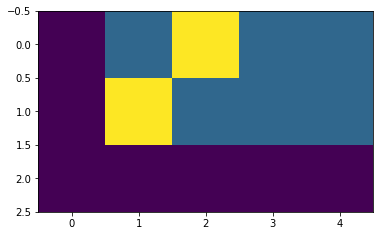

In [41]:
# 标签平滑示例:
from pyitcast.transformer_utils import LabelSmoothing

# 使用LabelSmoothing实例化一个crit对象.
# 第一个参数size代表目标数据的词汇总数, 也是模型最后一层得到张量的最后一维大小
# 这里是5说明目标词汇总数是5个. 第二个参数padding_idx表示要将那些tensor中的数字
# 替换成0, 一般padding_idx=0表示不进行替换. 第三个参数smoothing, 表示标签的平滑程度
# 如原来标签的表示值为1, 则平滑后它的值域变为[1-smoothing, 1+smoothing].
crit = LabelSmoothing(size=5, padding_idx=0, smoothing=0.5)

# 假定一个任意的模型最后输出预测结果和真实结果
predict = Variable(torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]]))

# 标签的表示值是0，1，2
target = Variable(torch.LongTensor([2, 1, 0]))

# 将predict, target传入到对象中
crit(predict, target)

# 绘制标签平滑图像
plt.imshow(crit.true_dist)

标签平滑图像分析:
- 我们目光集中在黄色小方块上, 它相对于横坐标横跨的值域就是标签平滑后的正向平滑值域, 我们可以看到大致是从0.5到2.5.
- 它相对于纵坐标横跨的值域就是标签平滑后的负向平滑值域, 我们可以看到大致是从-0.5到1.5, 总的值域空间由原来的[0, 2]变成了[-0.5, 2.5].

Label Smoothing 优势：
- 一定程度上，可以缓解模型过于武断的问题，也有一定的抗噪能力
- 弥补了简单分类中监督信号不足（信息熵比较少）的问题，增加了信息量；
- 提供了训练数据中类别之间的关系（数据增强）；
- 可能增强了模型泛化能力
- 降低feature norm （feature normalization）从而让每个类别的样本聚拢的效果
- 产生更好的校准网络，从而更好地泛化，最终对不可见的生产数据产生更准确的预测。

Label Smoothing 劣势：
- 单纯地添加随机噪音，也无法反映标签之间的关系，因此对模型的提升有限，甚至有欠拟合的风险。
- 它对构建将来作为教师的网络没有用处，hard 目标训练将产生一个更好的教师神经网络。

参考：https://cloud.tencent.com/developer/article/1815786

In [42]:
# 第三步: 运行模型进行训练和评估
# 导入模型单轮训练工具包run_epoch, 该工具将对模型使用给定的损失函数计算方法进行单轮参数更新.
# 并打印每轮参数更新的损失结果.
from pyitcast.transformer_utils import run_epoch

def run(model, loss, epochs=10):
    """模型训练函数, 共有三个参数, model代表将要进行训练的模型
       loss代表使用的损失计算方法, epochs代表模型训练的轮数"""

    # 遍历轮数
    for epoch in range(epochs):
        # 模型使用训练模式, 所有参数将被更新
        model.train()
        # 训练时, batch_size是20
        run_epoch(data_generator(V, 8, 20), model, loss)

        # 模型使用评估模式, 参数将不会变化
        model.eval()
        # 评估时, batch_size是5
        run_epoch(data_generator(V, 8, 5), model, loss)

In [43]:
# 进行10轮训练
epochs = 10

# model和loss都是来自上一步的结果
run(model, loss, epochs=10)

Epoch Step: 1 Loss: 3.161569 Tokens per Sec: 44.249847
Epoch Step: 1 Loss: 2.630562 Tokens per Sec: 440.305145
Epoch Step: 1 Loss: 2.566113 Tokens per Sec: 435.457977
Epoch Step: 1 Loss: 2.128421 Tokens per Sec: 434.347534
Epoch Step: 1 Loss: 2.346101 Tokens per Sec: 411.109985
Epoch Step: 1 Loss: 2.030735 Tokens per Sec: 396.337402
Epoch Step: 1 Loss: 2.052001 Tokens per Sec: 416.793304
Epoch Step: 1 Loss: 1.830256 Tokens per Sec: 415.468170
Epoch Step: 1 Loss: 1.819934 Tokens per Sec: 419.750763
Epoch Step: 1 Loss: 1.692110 Tokens per Sec: 423.628448
Epoch Step: 1 Loss: 1.961471 Tokens per Sec: 421.459839
Epoch Step: 1 Loss: 1.568776 Tokens per Sec: 423.292358
Epoch Step: 1 Loss: 1.727991 Tokens per Sec: 414.037262
Epoch Step: 1 Loss: 1.598043 Tokens per Sec: 427.933807
Epoch Step: 1 Loss: 1.587818 Tokens per Sec: 416.296326
Epoch Step: 1 Loss: 1.536362 Tokens per Sec: 412.452209
Epoch Step: 1 Loss: 1.553212 Tokens per Sec: 442.549957
Epoch Step: 1 Loss: 1.340495 Tokens per Sec: 444.

In [44]:
# 第四步: 使用模型进行贪婪解码
# 导入贪婪解码工具包greedy_decode, 该工具将对最终结进行贪婪解码
# 贪婪解码的方式是每次预测都选择概率最大的结果作为输出, 
# 它不一定能获得全局最优性, 但却拥有最高的执行效率.
from pyitcast.transformer_utils import greedy_decode 

# 模型进入测试模式
model.eval()

# 假定的输入张量
source = Variable(torch.LongTensor([[1,3,2,5,4,6,7,8,9,10]]))

# 定义源数据掩码张量, 因为元素都是1, 在我们这里1代表不遮掩
# 因此相当于对源数据没有任何遮掩.
source_mask = Variable(torch.ones(1, 1, 10))

# 最后将model, src, src_mask, 解码的最大长度限制max_len, 默认为10
# 以及起始标志数字, 默认为1, 我们这里使用的也是1
result = greedy_decode(model, source, source_mask, max_len=10, start_symbol=1)
print(result)

tensor([[ 1,  3,  2,  5,  4, 10,  6,  8,  7,  2]])


In [45]:
# 导入贪婪解码工具包greedy_decode, 该工具将对最终结进行贪婪解码
# 贪婪解码的方式是每次预测都选择概率最大的结果作为输出, 
# 它不一定能获得全局最优性, 但却拥有最高的执行效率.
from pyitcast.transformer_utils import greedy_decode 

# greedy_decode等解码算法：https://zhuanlan.zhihu.com/p/157966981
# 这个模型生成了我们单词的概率分布（实际上是logits）。橙色方框显示解码算法的选择，帮助我们选择使用哪个单词。然后，选择的单词和图像再次传递给模型，直到我们满足停止条件，即我们获得特殊的句子结束标记（即）作为下一个单词，或者我们超过了预先定义的步骤数。
# 与viterbi区别 维特比算法，专为全局最优而生。但他是建立在前后隐状态独立的条件下的（维特比算法使用的假设前提是：全局最优解＝各分段最优解之和）
# 参考：https://www.cnblogs.com/tibetanmastiff/p/13041973.html

def run(model, loss, epochs=10):
    for epoch in range(epochs):
        model.train()

        run_epoch(data_generator(V, 8, 20), model, loss)

        model.eval()

        run_epoch(data_generator(V, 8, 5), model, loss)

    # 模型进入测试模式
    model.eval()

    # 假定的输入张量
    source = Variable(torch.LongTensor([[1,3,2,5,4,6,7,8,9,10]]))

    # 定义源数据掩码张量, 因为元素都是1, 在我们这里1代表不遮掩
    # 因此相当于对源数据没有任何遮掩.
    source_mask = Variable(torch.ones(1, 1, 10))

    # 最后将model, src, src_mask, 解码的最大长度限制max_len, 默认为10
    # 以及起始标志数字, 默认为1, 我们这里使用的也是1
    result = greedy_decode(model, source, source_mask, max_len=10, start_symbol=1)
    print(result)


run(model, loss) 

Epoch Step: 1 Loss: 1.332195 Tokens per Sec: 396.585693
Epoch Step: 1 Loss: 1.117974 Tokens per Sec: 386.364319
Epoch Step: 1 Loss: 1.252390 Tokens per Sec: 423.947205
Epoch Step: 1 Loss: 1.057625 Tokens per Sec: 421.863739
Epoch Step: 1 Loss: 1.144346 Tokens per Sec: 421.535156
Epoch Step: 1 Loss: 0.846519 Tokens per Sec: 436.332520
Epoch Step: 1 Loss: 1.124123 Tokens per Sec: 413.177643
Epoch Step: 1 Loss: 0.714804 Tokens per Sec: 414.282379
Epoch Step: 1 Loss: 0.746808 Tokens per Sec: 405.208984
Epoch Step: 1 Loss: 0.551744 Tokens per Sec: 423.553864
Epoch Step: 1 Loss: 0.711003 Tokens per Sec: 420.057861
Epoch Step: 1 Loss: 0.441579 Tokens per Sec: 443.003082
Epoch Step: 1 Loss: 0.647053 Tokens per Sec: 419.513123
Epoch Step: 1 Loss: 0.468622 Tokens per Sec: 408.832825
Epoch Step: 1 Loss: 0.530857 Tokens per Sec: 417.024963
Epoch Step: 1 Loss: 0.288007 Tokens per Sec: 435.341522
Epoch Step: 1 Loss: 0.624052 Tokens per Sec: 418.758362
Epoch Step: 1 Loss: 0.185199 Tokens per Sec: 427

## transformer可以用来构建语言模型

以一个符合语言规律的序列为输入，模型将利用序列间关系等特征，输出一个在所有词汇上的概率分布.这样的模型称为语言模型.

语言模型的训练语料一般来自于文章，对应的源文本和目标文本形如:

    src1 = "I can do" tgt1 = "can do it"
    src2 = "can do it", tgt2 = "do it <eos>"

语言模型能解决哪些问题:
1. 根据语言模型的定义，可以在它的基础上完成机器翻译，文本生成等任务，因为我们通过最后输出的概率分布来预测下一个词汇是什么.
2. 语言模型可以判断输入的序列是否为一句完整的话，因为我们可以根据输出的概率分布查看最大概率是否落在句子结束符上，来判断完整性.
3. 语言模型本身的训练目标是预测下一个词，因为它的特征提取部分会抽象很多语言序列之间的关系，这些关系可能同样对其他语言类任务有 效果.因此可以作为预训练模型进行迁移学习.

-> 预训练语言模型